# WGAN



In [1]:
import os
import tensorflow
from tensorflow.keras.layers import Conv2DTranspose,BatchNormalization
from tensorflow.keras.layers import Input,LeakyReLU,Conv2D,Flatten,Dense,Activation,Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop
import numpy as np
from PIL import Image
from matplotlib.pyplot import imshow

### Load the data

In [2]:
from tensorflow.keras.datasets import mnist
(xtr,_),_ = mnist.load_data()
xtr = xtr.reshape((-1,28,28,1)).astype('float32')/255

### Create a dataViewer

In [3]:
%matplotlib inline
from GAN.utils import dataViewer

In [4]:
def viewMnist(mtr):
    '''Return from a numpy array an Image'''
    mtr = mtr.reshape((28,28))
    mtr *= 255
    mtr = np.clip(mtr,0,255).astype('uint8')
    imshow(mtr,cmap='gray')
def saveMnist(mtr,path):
    '''Save as file the numpy array'''
    mtr = mtr.reshape((28,28))
    mtr *= 255
    mtr = np.clip(mtr,0,255).astype('uint8')
    Image.fromarray(mtr).resize((280,280)).save(path)

In [5]:
vwr = dataViewer(functionView=viewMnist,functionSave=saveMnist,path="D:/Project/DeepLearning/GAN/WGAN/output/")

### Create a WGAN

In [6]:
from GAN.GAN.SimpleGAN import WGAN

In [7]:
def buildDisc():
    '''Buid the discriminator'''
    input_shape = (28, 28, 1)
    inputs = Input(shape=input_shape, name='discriminator_input')
    kernel_size = 5
    layer_filters = [32, 64, 128, 256]
    x = inputs
    for filters in layer_filters:
        # first 3 convolution layers use strides = 2
        # last one uses strides = 1
        if filters == layer_filters[-1]:
            strides = 1
        else:
            strides = 2
        x = LeakyReLU(alpha=0.2)(x)
        x = Conv2D(filters=filters,kernel_size=kernel_size,strides=strides,padding='same')(x)

    x = Flatten()(x)
    x = Dense(1,activation='linear')(x)

    return Model(inputs, x, name='discriminator')

discriminator = buildDisc()
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
discriminator_input (InputLa [(None, 28, 28, 1)]       0         
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 32)        832       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          51264     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)       

In [8]:
def buildGen():
    '''Build the generator'''
    image_resize = 7
    # network parameters
    kernel_size = 5
    layer_filters = [128, 64, 32, 1]
    
    inputs = Input(shape=100,name='generator_input')
    x = inputs

    x = Dense(image_resize * image_resize * layer_filters[0])(x)
    x = Reshape((image_resize, image_resize, layer_filters[0]))(x)

    for filters in layer_filters:
        if filters > layer_filters[-2]:
            strides = 2
        else:
            strides = 1
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2DTranspose(filters=filters, kernel_size=kernel_size,strides=strides,padding='same')(x)

    x = Activation('sigmoid')(x)
    return Model(inputs, x, name='generator')

generator = buildGen()
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator_input (InputLayer) [(None, 100)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 128)         512       
_________________________________________________________________
activation (Activation)      (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       409728    
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 128)       51

In [9]:
gan = WGAN(generator=generator,discriminator=discriminator,DiscrOptimizer=RMSprop(lr=5e-5),GanOptimizer=RMSprop(lr=5e-5))

In [10]:
gan.generateBatchEval()

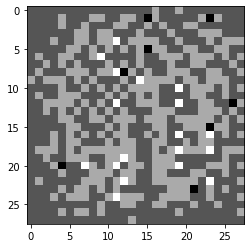

In [11]:
gan.GenerateOutputs(xtest=gan.evaluationInpt,returnArray=False,dataViewer=vwr,save=True,View=False,epoch=0)
gan.GenerateOutputs(batchSize=1,returnArray=False,dataViewer=vwr,save=False,View=True,epoch=0)

In [12]:
gan.train(xtr,epoch=300,batch_size=1024,evalStep=(10,100), n_critic = 5,clip_value = 0.01,pathSave='D:/Project/DeepLearning/GAN/WGAN/save',dataViewer=vwr)

Epoch 300
11/11 [==============================] - 52s 5s/step
Discrimiator: (loss,acc)=(-0.013973575085401539,0.0001953125)
 	 Adversial: (loss,acc)=(-0.02002800814807415,0.0009765625)
